# Bias correcting daily WRF precipitation using a probabilistic neural network  


### Import required packages 

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import os, shutil, time, pdb, random
import scipy.stats as stats 
import scipy

from math import pi
from datetime import datetime
from collections import OrderedDict
import pickle

import torch
from torch.utils.data import TensorDataset, DataLoader 

from importlib import reload
from models import *
from utils import *
from runmanager import *
from experiment import *
from plot_utils import *
from preprocessing_utils import *
from analysis_seasonal import * 

from sklearn.metrics import mean_squared_error as mse

import matplotlib
matplotlib.rc_file_defaults()
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
from tabulate import tabulate

pd.options.display.max_columns = None

np.random.seed(4)

%load_ext autoreload
%autoreload 2

# Detect device.
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import data

In [145]:
# Parameters
start="1998-01-01"
end="2015-12-31"

TRAIN_PATH = '../../data/norris/enriched_obs/enriched_combined_obs_norris_ready.pkl'
# TEST_PATH = "../data/pickle/df_stations_val_all_nonzero_extended.pkl"

In [146]:
# st = create_station_dataframe(TRAIN_PATH, start, end, add_yesterday=True, basin_filter = None, filter_incomplete_years = True)

data = DataPreprocessing(train_path=TRAIN_PATH, start=start, end=end, 
                add_yesterday = False, 
                basin_filter = None, 
                split_bias_corrected_only = False, 
                filter_incomplete_years = False, 
                include_non_bc_stations = True, 
                split_by = 'station')

In [148]:
data.split_stations()

In [149]:
data.st['doy'] = data.st['Date'].dt.dayofyear

data.st['doy_sin'] = data.st['doy'].transform(lambda x: np.sin(x))
data.st['doy_cos'] = data.st['doy'].transform(lambda x: np.cos(x))

In [150]:
# data.st.describe()

### Split data into held out sets for K-fold cross validation

### Prepare data

In [151]:
predictors = [ 
                'doy_sin',
                'doy_cos',
                'Z',
#                 'X',
#                 'Y',
                #'aspect',
                #'slope',
#                 'year',
                'CWV_norris', 'RH2_norris', 'RH500_norris', 
                'T2_norris', 'T2max_norris','T2min_norris', 'Td2_norris', 
                'precip_norris', 'rain_norris', 
                'cape_norris',
                'u10_norris', 'v10_norris', 
                'u250_norris', 'v250_norris', 'w250_norris', 
                'u500_norris', 'v500_norris', 'w500_norris',
                'hgt_norris', 'lu_index_norris', 
#     'xland_norris'
              ]

# predictors.append('obs_yesterday')

predictand = ['Prec']

data.input_data(predictors, predictand, sort_by_quantile=False)

### Train model with single run

In [152]:
batch_size = 128

train_loader = DataLoader(dataset=data.train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(dataset=data.val_dataset, batch_size=1024, shuffle=False)
test_loader = DataLoader(dataset=data.test_dataset, batch_size=1024, shuffle=False)

In [153]:
model = MLP(in_channels=data.d, 
            hidden_channels=[30, 30], 
            likelihood_fn='bgmm', # 'gaussian', gamma', 'ggmm', bgmm', 'b2gmm', 'b2sgmm'
            dropout_rate=0,
           )

print(f'Number of parameters: {sum(p.numel() for p in model.parameters())}')

Number of parameters: 1743


In [154]:
experiment_name = f'MLP_{model.likelihood}'
wd = WorkingDirectory(generate_root(experiment_name))

# Save model parameters
arg_list = ['in_channels','hidden_channels','likelihood','dropout_rate']
model_args = {}

for k in arg_list:
    model_args[k] = getattr(model, k)

with open(os.path.join(wd.root,'model_args.pickle'), 'wb') as handle:
    pickle.dump(model_args, handle, protocol=pickle.HIGHEST_PROTOCOL)

train_losses = []
val_losses = []
test_losses = []

epochs = 25

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):

    train_loss, val_loss, test_loss = train_epoch(model, optimizer, train_loader, valid_loader, test_loader=test_loader, print_progress=True, epoch=epoch)
    
    # wandb.log({"train_loss":train_loss, "val_loss":val_loss, "test_loss":test_loss})
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)
    
    save_as_best = True if val_loss == min(val_losses) else False
    save_checkpoint(wd,model.state_dict(),is_best=save_as_best)
    
    PATH = os.path.join(wd.root,'e_%s_loss_%.3f.pth.tar' % (epoch, val_loss))
    torch.save(model.state_dict(), PATH)

BEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
model.load_state_dict(torch.load(BEST_PATH))

Root: /data/hpcdata/users/marron31/_experiments/XYEPUMFALw_mlp-bgmm
epoch : 1, train loss : 1.2217, valid loss : 1.2858
epoch : 2, train loss : 1.1459, valid loss : 1.2805
epoch : 3, train loss : 1.1390, valid loss : 1.2852
epoch : 4, train loss : 1.1351, valid loss : 1.2836
epoch : 5, train loss : 1.1324, valid loss : 1.2903
epoch : 6, train loss : 1.1299, valid loss : 1.3294
epoch : 7, train loss : 1.1288, valid loss : 1.3346
epoch : 8, train loss : 1.1268, valid loss : 1.2964
epoch : 9, train loss : 1.1258, valid loss : 1.3116
epoch : 10, train loss : 1.1246, valid loss : 1.2839
epoch : 11, train loss : 1.1234, valid loss : 1.3094
epoch : 12, train loss : 1.1217, valid loss : 1.3602
epoch : 13, train loss : 1.1208, valid loss : 1.3572
epoch : 14, train loss : 1.1202, valid loss : 1.3298
epoch : 15, train loss : 1.1192, valid loss : 1.3399
epoch : 16, train loss : 1.1186, valid loss : 1.3524
epoch : 17, train loss : 1.1179, valid loss : 1.3382
epoch : 18, train loss : 1.1170, valid l

<All keys matched successfully>

In [155]:
LOAD_CHECKPOINT = False
LOAD_MODELBEST = True

if LOAD_CHECKPOINT and LOAD_MODELBEST:
    print("\n Both LOAD_CHECKPOINT and LOAD_MODELBEST flags are set to True. \n PLEASE SET ONLY ONE TO TRUE")

elif LOAD_CHECKPOINT:
    CHECKPOINT_PATH = os.path.join(wd.root,'checkpoint.pth.tar')
    model.load_state_dict(torch.load(CHECKPOINT_PATH))

elif LOAD_MODELBEST:
    MODELBEST_PATH = os.path.join(wd.root,'model_best.pth.tar')
    model.load_state_dict(torch.load(MODELBEST_PATH))

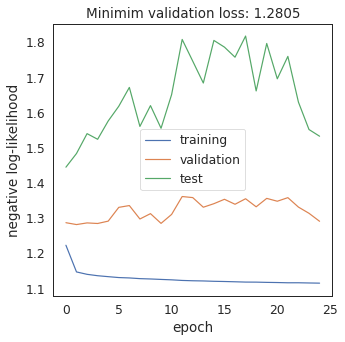

In [156]:
# Figure
plot_losses(train_losses, val_losses, test_losses)  

In [157]:
test_outputs = make_predictions(model, data.test_dataset)

In [158]:
from captum.attr import IntegratedGradients, NoiseTunnel, DeepLift, GradientShap, FeatureAblation

In [159]:
X_test = data.test_dataset.tensors[0]

In [160]:
ig = IntegratedGradients(model)
# ig_nt = NoiseTunnel(ig)
# dl = DeepLift(model)
# gs = GradientShap(model)
fa = FeatureAblation(model)

In [161]:
fa_attr_test = fa.attribute(X_test,target=1, show_progress=True)

Feature Ablation attribution: 100%|██████████| 24/24 [00:00<00:00, 157.84it/s]


In [83]:
%%time

# attr = ig.attribute(X_test, n_steps=50, target=0)

attr0, delta0 = ig.attribute(X_test, target=0, return_convergence_delta=True)
attr1, delta1 = ig.attribute(X_test, target=1, return_convergence_delta=True)
attr2, delta2 = ig.attribute(X_test, target=2, return_convergence_delta=True)

# ig_nt_attr_test = ig_nt.attribute(X_test, target=0)
# dl_attr_test = dl.attribute(X_test,target=0)
# gs_attr_test = gs.attribute(X_test, X_train)
# fa_attr_test = fa.attribute(X_test)

CPU times: user 6min 11s, sys: 1.94 s, total: 6min 13s
Wall time: 5min 55s


In [ ]:
plt.hist(delta, bins=10)
plt.show()

In [ ]:
plt.hist(attr[:,5].detach().numpy(), bins=20)
plt.show()

Average Feature Importances
doy_sin :  -0.001 0.022 0.019
doy_cos :  -0.001 0.019 0.017
Z :  -0.007 0.217 0.102
CWV_norris :  -0.022 0.095 0.045
RH2_norris :  -0.015 0.141 0.131
RH500_norris :  -0.004 0.081 0.069
T2_norris :  0.015 0.069 0.113
T2max_norris :  0.006 0.096 0.102
T2min_norris :  0.002 0.117 0.153
Td2_norris :  -0.050 0.167 0.021
precip_norris :  -0.005 0.016 0.013
rain_norris :  -0.005 0.022 0.011
cape_norris :  -0.052 0.162 0.044
u10_norris :  -0.007 0.076 0.057
v10_norris :  0.004 0.024 0.034
u250_norris :  0.006 0.044 0.061
v250_norris :  -0.007 0.044 0.024
w250_norris :  0.003 0.049 0.042
u500_norris :  -0.009 0.049 0.022
v500_norris :  0.012 0.035 0.073
w500_norris :  -0.002 0.032 0.037
hgt_norris :  -0.032 0.156 0.084
lu_index_norris :  -0.010 0.092 0.071


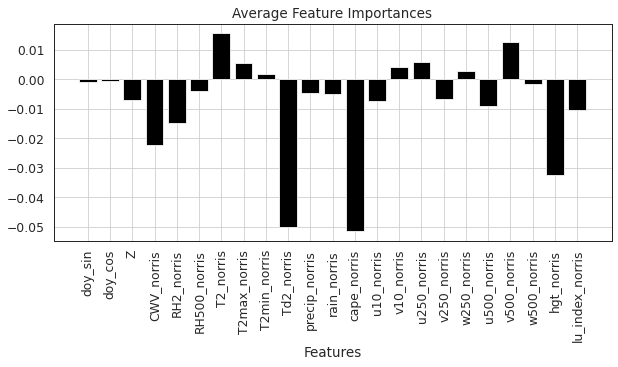

In [88]:
# Helper method to print importances and visualize distribution
def visualize_importances(feature_names, attr, title="Average Feature Importances", plot=True, axis_title="Features"):
    
    attr = attr.detach().numpy()
    
    importances = np.mean(attr, axis=0)
    error_bars = np.stack([-np.quantile(attr, 0.1, axis=0),np.quantile(attr, 0.9, axis=0)])
                          
    print(title)
    for i in range(len(feature_names)):
#         pass
        print(feature_names[i], ": ", f"{importances[i]:.3f} {error_bars[0,i]:.3f} {error_bars[1,i]:.3f}")
    x_pos = (np.arange(len(feature_names)))
    if plot:
        plt.figure(figsize=(10,4))
#         plt.bar(x_pos, importances,yerr=error_bars, align='center',capsize=10, color='black', ecolor='black', width=0.5)
        plt.bar(x_pos, importances,align='center',capsize=10, color='black',)    
        plt.xticks(x_pos, feature_names, wrap=False, rotation=90)
        plt.xlabel(axis_title)
        plt.title(title)
        plt.grid()
        
# visualize_importances(predictors, np.mean(attr0.detach().numpy(), axis=0))
# visualize_importances(predictors, np.mean(attr1.detach().numpy(), axis=0))
# visualize_importances(predictors, np.mean(attr2.detach().numpy(), axis=0))

visualize_importances(predictors, fa_attr_test)

In [22]:
# PATH = '../../PhD/data/pickle/df_map1.pkl'
# test_map = pd.read_pickle(PATH)

# data['X_map'] = (test_map[predictors].to_numpy() - x_mean) / x_std

# model.eval()

# with torch.no_grad():
#     map_inputs = torch.Tensor(data['X_map'][:,:d])
#     map_outputs = model(map_inputs)

In [23]:
# %%time
# map_results = build_results_df(test_map,
#                        outputs=map_outputs,
#                        st_names_test=None,
#                        model=model,
#                        p=0.05,
#                        confidence_intervals=True)

In [24]:
# from scipy.interpolate import griddata

# xRange = np.sort(map_results['X'].unique())
# yRange = np.sort(map_results['Y'].unique())
# points = list(zip(map_results.X,map_results.Y))
# values = map_results['wrf_prcp'].values

# #create arrays of x,y over the raster extension
# gridX,gridY = np.meshgrid(xRange,yRange)

# #interpolate over the grid
# gridValues = griddata(points, values, (gridX,gridY), method='linear')

# #show interpolated values
# plt.imshow(gridValues)
# plt.gca().invert_yaxis()
# plt.xticks([]), plt.yticks([])
# plt.show()

In [25]:
# n = 2
# fig, axes = plt.subplots(1,n,figsize=(n*5 + 5, 5))
# cols = ['wrf_prcp','sample_0','high_ci','low_ci','Z']
# labels = ['WRF', 'Samples']
# a = ['a','b']

# map_results = build_results_df(test_map,
#                            outputs=map_outputs,
#                            st_names_test=None,
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            )

# for index, ax in enumerate(axes.flatten()):
    
#     if index < len(cols):
#         col = cols[index]
#     else:
#         col = cols[-1]
    
#     ax.scatter(x=map_results['X'], y=map_results['Y'], c=map_results[col], cmap="viridis")
#     #ax.set_title(labels[index], fontsize=16)
#     ax.set_xticklabels([]), ax.set_yticklabels([])
#     ax.set_frame_on(False)
#     ax.set_xticks([]), ax.set_yticks([])
#     #ax.set_frame_on(True)
    
#     ax.text(0.06, 0.90, f'{a[index]}', fontweight="bold", transform=ax.transAxes, size='large', color='white')#bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
# plt.tight_layout(w_pad=-1.5)
# plt.savefig('figures/sampled_map', dpi=300)
# plt.show()

In [26]:
# concat_test_output = make_sequential_predictions(model, data.test_dataset, data.x_mean, data.x_std)

### Histograms of predicted parameter values 

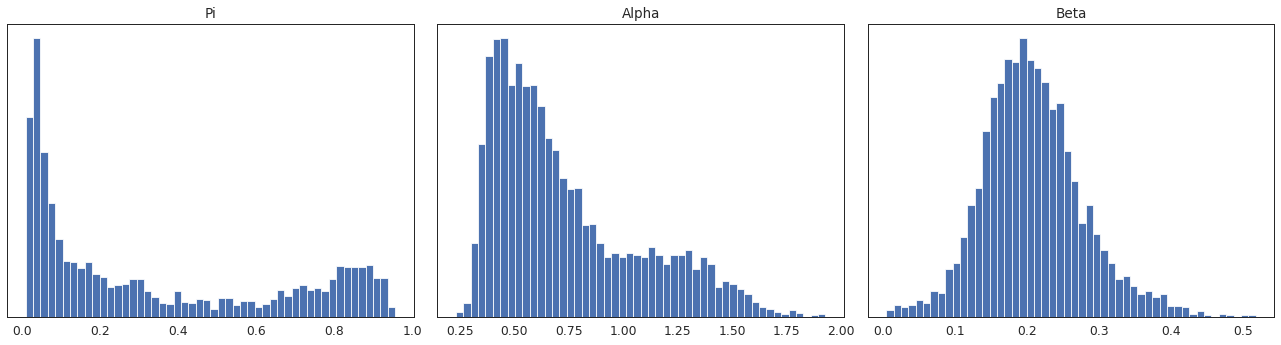

In [27]:
plot_parameter_histograms(model, test_outputs)

In [29]:
# plot_parameter_histograms(model, concat_test_output[:,:-1])

In [30]:
# # %%capture

# sns.set_theme(context='paper',style='white',font_scale=1.4)

# title_labels = ['pi', 'alpha', 'beta'] 

# fig, axes = plt.subplots(1,3, figsize=(15,5))

# for idx, ax in enumerate(axes.flatten()):
#     for i in [0,1,5,10,50,100]:
#         zero_wrf = test_dataset.tensors[0][:,0].mode()[0] 
#         test_inputs = test_dataset.tensors[0].clone()
#         test_inputs[:,0:1] = zero_wrf + (i-x_mean[0])/x_std[0]
#         model.eval()
#         with torch.no_grad():
#             test_outputs = model(test_inputs)
#         if idx==0:
#             ax.plot(1-test_outputs[:,idx], label=i, linewidth=1.5)
#         else:
#             ax.plot(test_outputs[:,idx], label=i, linewidth=1.5)
#     if idx==1:
#         ax.legend(title="P$_{SIM}$ (mm/day)", loc="lower left")
#     ax.set_xlim(0,365)
#     ax.set_xticks([0,365])
#     #ax.set_title(title_labels[idx])
#     ax.set_xlabel("Day of year")
#     ax.set_ylabel(title_labels[idx].capitalize())
        
# plt.tight_layout()
# plt.savefig('figures/parameter_timeseries.png',dpi=300)
# plt.show()

In [31]:
%%capture

# sns.set_theme()
# list_of_stations = ['Berthin','Daslehra']
# # fig, axes = plt.subplots(1,2,figsize=(10,5))
# # for idx, ax in enumerate(axes.flatten()):
# #     s = list_of_stations[idx]
# #     df = st_test[st_test['Station']==s]
# #     y = df['sample']-df['Prec']
# #     ax.scatter(x=df['Prec'],y=y,label=s)
# #     ax.legend()

# df = clip_time_period(st_test,'2000-01-01','2005-01-31')
# df = df[df['Station'].isin(list_of_stations)]
# df['residuals'] = df['sample'] - df['Prec']
# #df.groupby(['Station'])['wrf_prcp'].first().unstack()#.unstack()
# df = df.pivot(index='Date',
#         columns='Station',
#         values='residuals')

# df.dropna(inplace=True)
# # df1 = df[df['Station']=='Sainj']
# # y1 = df1['wrf_prcp']-df1['Prec']
# # df2 = df[df['Station']=='Larji']
# # y2 = df2['wrf_prcp']-df2['Prec']
# plt.scatter(df[list_of_stations[0]],df[list_of_stations[1]])
# plt.show()

# np.corrcoef(df[list_of_stations[0]],df[list_of_stations[1]])

### Plot sample distribution

In [32]:
# plot_sample_distribution(model, outputs, test_dataset, force_non_zero=True)

### Summary of results

In [33]:
n_samples = 1

In [34]:
# st_test = st[(st['year'].isin(years_dict['test']))]
# st_test[['pi','alpha','beta','sample_0']] = bs.numpy()

In [35]:
data.st_names_dict['test']

['Bhuntar', 'Kasol', 'Sujanpur', 'Hamirpur', 'Karsog', 'BanjarIMD']

In [36]:
split_by = 'station'

In [37]:
%%time

if split_by == 'year':
    input_df = data.st[(data.st['year'].isin(years_dict['test']))].copy()
    input_st_names = None 
elif split_by == 'station':
    input_df = data.st.copy()
    input_st_names = data.st_names_dict['test']
    

# st_test = build_results_df(df=input_df,
#                            outputs= test_outputs, #bs[:,:3],#test_outputs,
#                            st_names_test=input_st_names, #st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            draw_samples=True,
#                            n_samples=n_samples)


# Build results dataframe
st_test = build_results_df(df = input_df,
                           test_dataset = data.test_dataset,
                           st_names_test = input_st_names, #st_names_dict['test'],
                           model = model,
                           p = 0.05,
                           confidence_intervals = True,
                           draw_samples = True,
                           n_samples = n_samples,
                           sequential_samples = True,
                           x_mean = data.x_mean,
                           x_std = data.x_std)

0
10000
CPU times: user 7.76 s, sys: 134 ms, total: 7.9 s
Wall time: 7.77 s


In [38]:
# st_test['sample_0'] = bs[:,-1]

In [39]:
st_test = st_test[st_test['Station'].isin(st_names)].copy() if split_by == 'year' else st_test

In [40]:
# %%time
# st_test = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True,
#                            calculate_errors=True,
#                            n_samples=3)

In [41]:
# list_wet_days_mlp = []

# for i in range(10):
    
#     df = build_results_df(st,
#                            outputs=test_outputs,
#                            st_names_test=st_names_dict['test'],
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

#     wet_days_mlp = (df['sample']!=0).sum()
#     # print(i, wet_days_mlp)

#     list_wet_days_mlp.append(wet_days_mlp)
    
# wet_days_reg = (df['wrf_bc_prcp']!=0).sum()
# wet_days_obs = (df['Prec']!=0).sum()

In [42]:
# plt.plot(list_wet_days_mlp,'o')
# plt.plot([0,9],[np.mean(list_wet_days_mlp),np.mean(list_wet_days_mlp)])
# plt.plot([wet_days_obs]*10)
# plt.plot([wet_days_reg]*10)
# plt.show()

In [43]:
# np.mean(list_wet_days_mlp/wet_days_obs) , np.std(list_wet_days_mlp/wet_days_obs)

# print(f"Ratio of predicted vs actual wet days (BC): {wet_days_reg / wet_days_obs:.4f}")
# print(f"Ratio of predicted vs actual wet days (MLP): {np.mean(list_wet_days_mlp/wet_days_obs):.4f}")

In [44]:
# st_test = build_results_df(st_val,
#                            outputs=test2_outputs,
#                            st_names_test=st_val['Station'].unique(),
#                            model=model,
#                            p=0.05,
#                            confidence_intervals=True)

In [45]:
# predictions.keys()

In [46]:
# st_test = predictions['bgmm_[30]_False']['k_all'].copy()

In [47]:
st_test['sample_0'] = st_test['sample']

In [48]:
# st_test = st_test[st_test['Station'].isin(st_names)].copy()
st_test['sample_0'].sort_values(ascending=False).head(5)

179546    205.380890
71369     161.840851
181437    154.559586
71010     135.063797
79683     134.054337
Name: sample_0, dtype: float64

In [49]:
almost_dry = 0
n_samples= 1

print(f"Ratio of predicted vs actual wet days (BC): {(st_test['wrf_bc_prcp']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    print(f"Ratio of predicted vs actual wet days (MLP) {i}: {(st_test[f'sample_{i}']>almost_dry).sum() / (st_test['Prec']>almost_dry).sum():.4f}")

for i in range(n_samples):
    tail_high = (st_test[f'sample_{i}']>st_test['high_ci']).sum()
    tail_low = (st_test[f'sample_{i}']<st_test['low_ci']).sum()

    print(f"Percentage of high outliers at 95% confidence: {(tail_high) / len(st_test):.4f}")
    print(f"Percentage of low outliers at 95% confidence: {(tail_low) / len(st_test):.4f}")

Ratio of predicted vs actual wet days (BC): 1.0999
Ratio of predicted vs actual wet days (MLP) 0: 0.9190
Percentage of high outliers at 95% confidence: 0.0359
Percentage of low outliers at 95% confidence: 0.0000


In [50]:
print_average_yearly_dd_and_ci(st_test, almost_dry, n_samples)

Average CI per station: 0.0357
Mean factor of dry days per station: 0.9426
Mean factor of dry days per station (WRF): 1.123


In [51]:
# st_test_nontruncated = st_test.copy()

# for i in range(n_samples):
#     st_test[f'sample_{i}'] = st_test[f'sample_{i}'].apply(lambda x: truncate_sample(x))

In [52]:
st_test = pairwise_errors(st_test)
pairwise_mse = st_test.groupby(['Station']).mean()[['se_wrf','se_bcp']+[f'se_mlp_sample_{i}' for i in range(n_samples)]].reset_index()
pairwise_mse.mean()

se_wrf             158.347017
se_bcp             162.796362
se_mlp_sample_0    160.217044
dtype: float64

In [53]:
n_samples = 1

### Plot squared errors

In [54]:
sample_cols = [f'sample_{i}' for i in range(n_samples)]
add_cols = []

columns = ['Prec','wrf_prcp','wrf_bc_prcp'] + sample_cols + add_cols
labels = ['Obs', 'WRF', 'Bias corrected WRF','Sample (MLP)']

seasons = st_test['season'].unique()
basins = st_test['Basin'].unique()

In [55]:
#st_test['sample']=st_test['sample_1'].astype('float64').copy()

In [56]:
len(st_test['Station'].unique())

6

## Seasonal predictions

In [57]:
# st_test = st_test[st_test['median']>200]

### Analsys of results (per season per year)

In [58]:
df_annual = st_test.groupby(['Station','year','Basin']).sum()[columns].copy()
df_annual['sample'] = df_annual[sample_cols].mean(axis=1)

df_annual['se_wrf'] = (df_annual['wrf_prcp'] - df_annual['Prec'])**2
df_annual['se_wrf_bc'] = (df_annual['wrf_bc_prcp'] - df_annual['Prec'])**2

for i in range(n_samples):
    df_annual[f'se_mlp_{i}'] = (df_annual[f'sample_{i}'] - df_annual['Prec'])**2
df_annual['se_mlp'] = df_annual[[f'se_mlp_{i}' for i in range(n_samples)]].mean(axis=1)


annual_totals = df_annual.reset_index().melt(id_vars=['Station','year','Basin'],
                      value_vars=['Prec','wrf_prcp','wrf_bc_prcp','sample'] + add_cols
                     )   

annual_se = df_annual.reset_index().melt(id_vars=['Station','year','Basin'],
                      value_vars=['se_wrf','se_wrf_bc','se_mlp']
                     )  

rmse = np.sqrt(annual_se.groupby(['Basin','variable']).mean())

In [59]:
%%time 
df = seasonal_analysis(st_test, columns, n_samples, sample_cols, add_cols)
seasonal_dict = seasonal_summaries(df, add_cols)

CPU times: user 230 ms, sys: 2.95 ms, total: 233 ms
Wall time: 233 ms


In [63]:
df_multiyear = df.groupby(['Station','season']).mean()[columns + ['sample']].reset_index()
df_annual_multiyear = df_annual.groupby(['Station']).mean()[columns + ['sample']].reset_index()

table = []
sample_flag = 0 # 'all' or 0, 1, 2,...
sample_name = 'sample' if sample_flag == 'all' else f'sample_{sample_flag}'

for season in seasons:
    
    dfp = df_multiyear[df_multiyear['season']==season]
    a = abs(dfp['wrf_prcp'] - dfp['Prec'])/(dfp['wrf_prcp'] + dfp['Prec'])
    b = abs(dfp['wrf_bc_prcp'] - dfp['Prec'])/(dfp['wrf_bc_prcp'] + dfp['Prec'])
    c = abs(dfp[sample_name] - dfp['Prec'])/(dfp[sample_name] + dfp['Prec'])
    d = abs(dfp['sample'] - dfp['Prec'])/(dfp['sample'] + dfp['Prec'])
    row = [f'{season}', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{d.mean():.2f}', 
                        f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}', f'{d.median():.2f}']
    table.append(row)

dfp = df_annual_multiyear
a = abs(dfp['wrf_prcp'] - dfp['Prec'])/(dfp['wrf_prcp'] + dfp['Prec'])
b = abs(dfp['wrf_bc_prcp'] - dfp['Prec'])/(dfp['wrf_bc_prcp'] + dfp['Prec'])
c = abs(dfp[sample_name] - dfp['Prec'])/(dfp[sample_name] + dfp['Prec'])
d = abs(dfp['sample'] - dfp['Prec'])/(dfp['sample'] + dfp['Prec'])
row = ['All year', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{d.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}', f'{d.median():.2f}']
table.append(row)

headers = ['Season', 'Mean WRF', 'Mean CANLR', 'Mean MLP', 'Mean MLP (k=10)', 
                     'Median WRF', 'Median CANLR', 'Median MLP', 'Median MLP (k=10)']

print(tabulate(table, headers, tablefmt='simple'))

Season               Mean WRF    Mean CANLR    Mean MLP    Mean MLP (k=10)    Median WRF    Median CANLR    Median MLP    Median MLP (k=10)
-----------------  ----------  ------------  ----------  -----------------  ------------  --------------  ------------  -------------------
Winter (JFM)             0.14          0.09        0.12               0.12          0.11            0.06          0.14                 0.14
Premonsoon (AM)          0.38          0.09        0.11               0.11          0.39            0.09          0.11                 0.11
Monsoon (JJAS)           0.21          0.11        0.14               0.14          0.24            0.1           0.13                 0.13
Postmonsoon (OND)        0.25          0.15        0.27               0.27          0.18            0.1           0.3                  0.3
All year                 0.18          0.1         0.07               0.07          0.19            0.09          0.04                 0.04


In [64]:
# sns.histplot(data=e[e['variable']=='e_mlp'], x='value')
# plt.show()

Figure: total precipitation SMAPE per season and per station

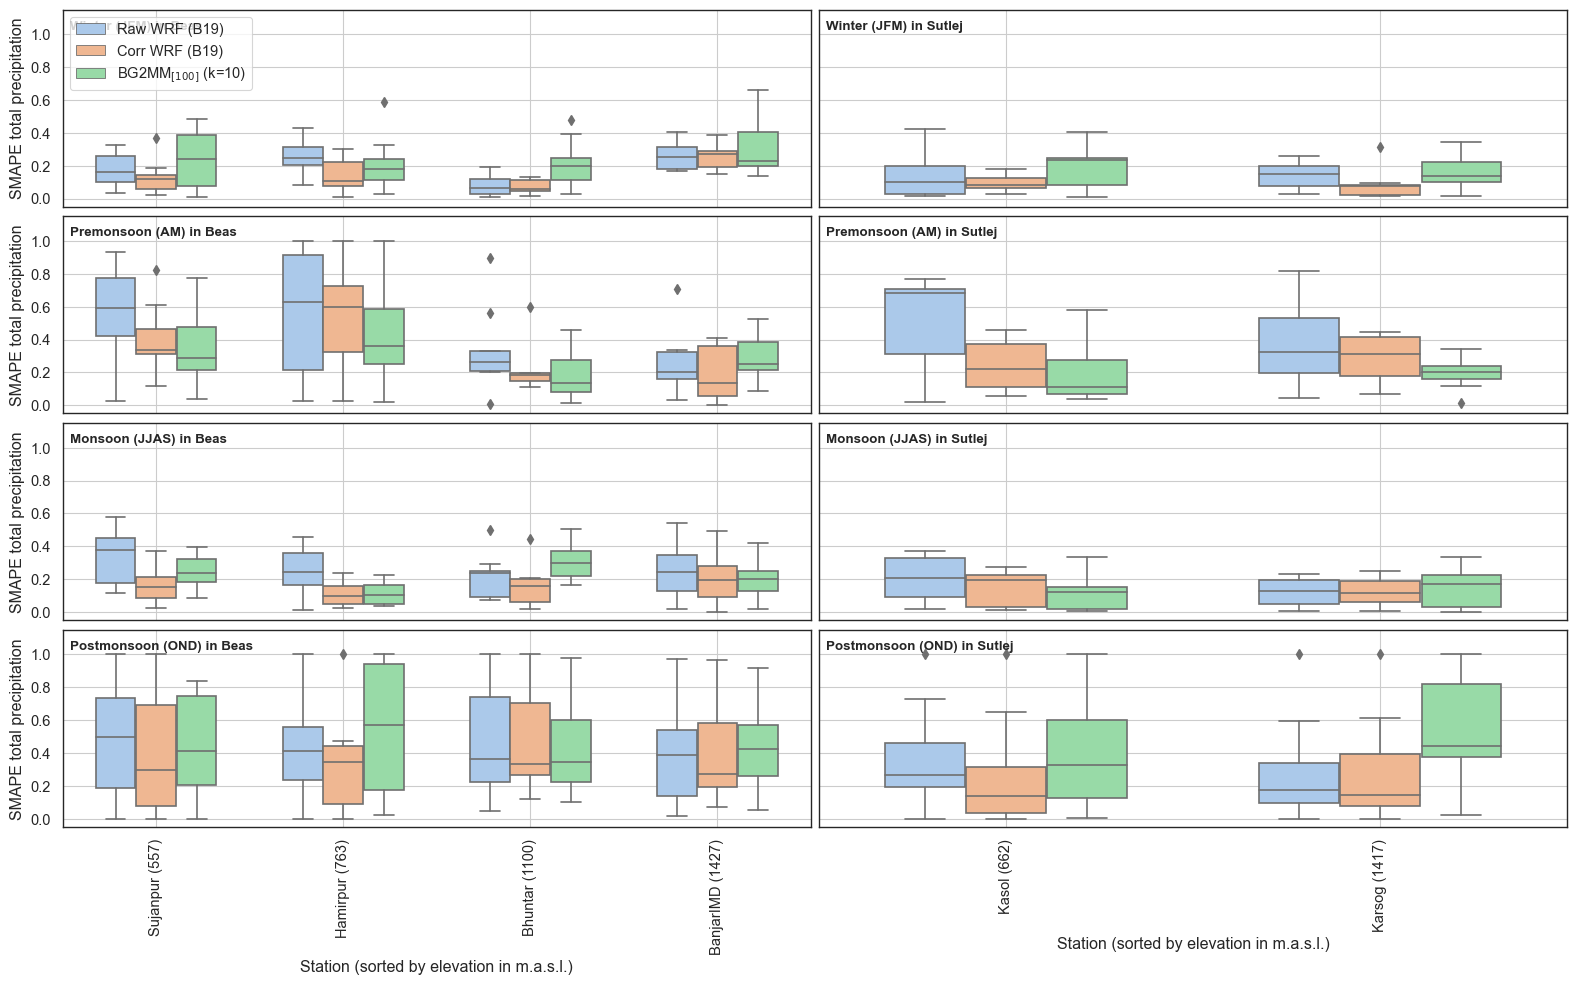

In [65]:
data1 = seasonal_dict['smape'].copy()
sns.set_theme(context='paper',style='white',font_scale=1.2)
new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','BG2MM$_{[100]}$ (k=10)']
# yaxislabel = 'Error reduction (mm)'
filter_by_basin_flag=False

plot_seasonal_boxplot_per_station(data1, st_test, yaxislabel='SMAPE total precipitation', new_labels=new_labels, 
                                basins=basins, seasons=seasons, filter_by_basin_flag=filter_by_basin_flag, y_limits=[-0.05,1.15])

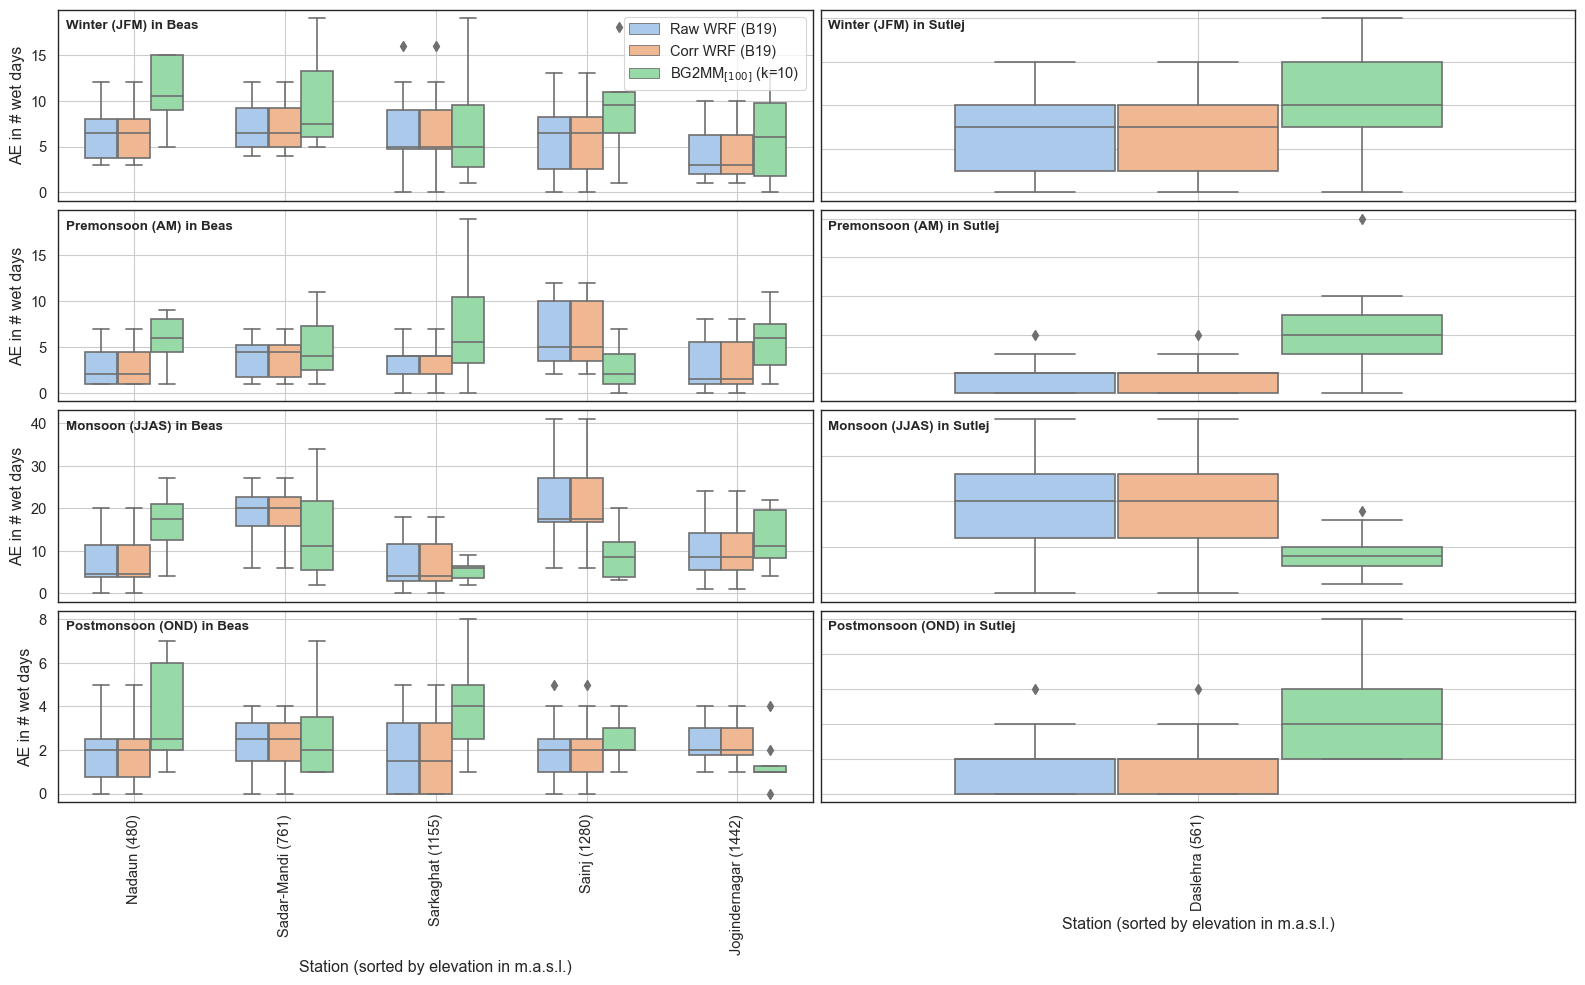

In [86]:
data1 = seasonal_dict['edd'].copy()
sns.set_theme(context='paper',style='white',font_scale=1.2)
new_labels = ['Raw WRF (B19)', 'Corr WRF (B19)','BG2MM$_{[100]}$ (k=10)']

plot_seasonal_boxplot_per_station(data1, st_test, yaxislabel='AE in # wet days', new_labels=new_labels, 
                                basins=basins, seasons=seasons, filter_by_basin_flag=filter_by_basin_flag, y_limits=None)

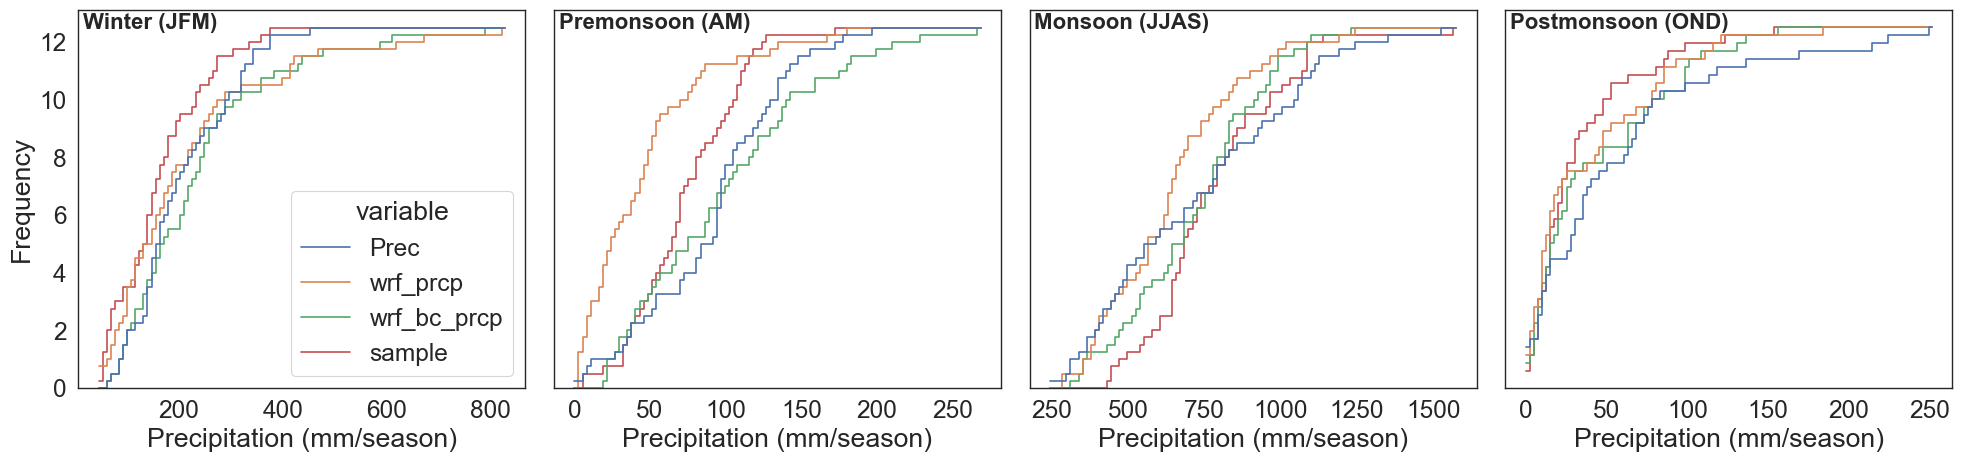

In [74]:
plot_cumulative_histograms_per_season(seasonal_dict, seasons)

### Seasonal over the entire period

In [90]:
# st_test_season_totals = st_test.groupby(['Station','season']).sum()
# st_test_annual_totals = st_test.groupby(['Station']).sum()

NameError: name 'st_test_season_totals' is not defined

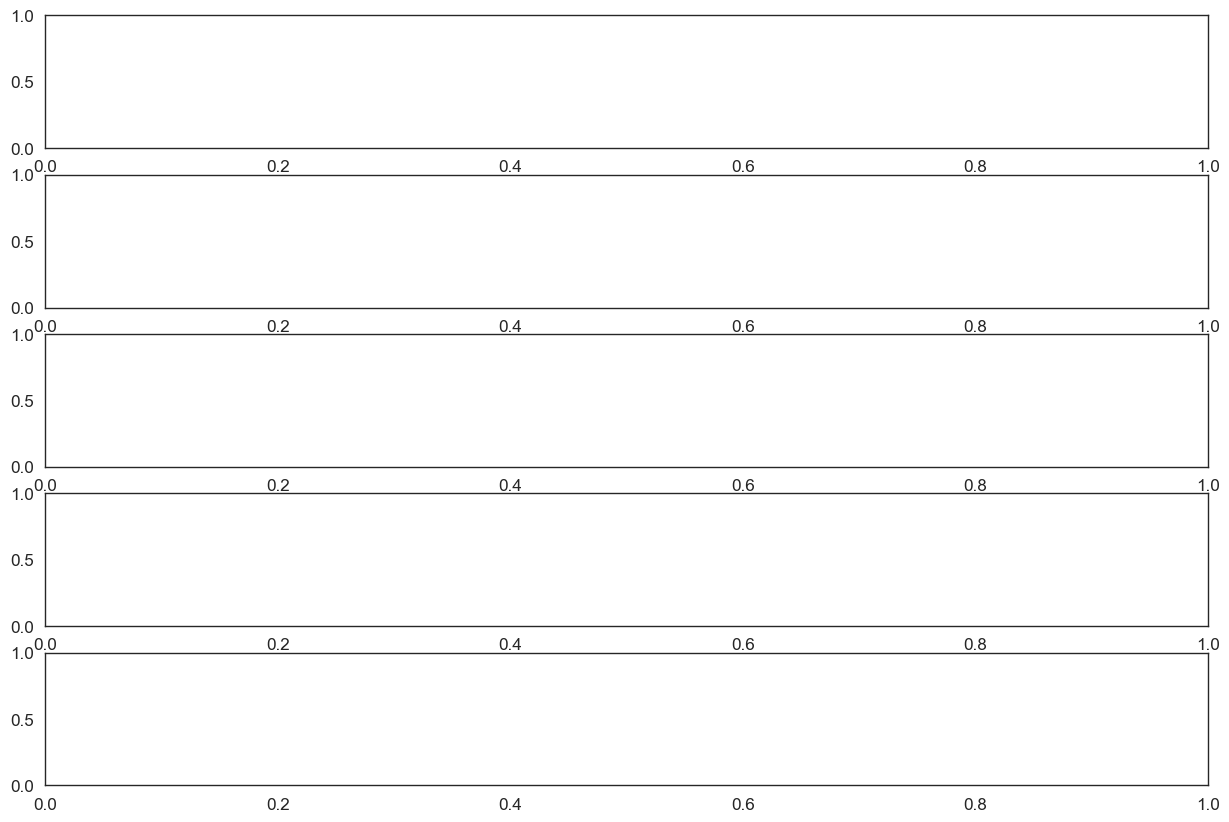

In [75]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

fig, axes = plt.subplots(5,1, figsize=(15,10))

for i, ax in enumerate(axes.flatten()):

    if i < 4: 

        season = seasons[i]
        df = st_test_season_totals[np.in1d(st_test_season_totals.index.get_level_values(1), [season])].copy()
        df = df.reset_index().set_index('Station')

    else: 
        df = st_test_annual_totals
        season = "Annual"

    legend = True if i==0 else None
    df[list(columns[l] for l in [0,1,2,3])].plot.bar(rot=45,ax=ax,legend=legend)

    df['se_wrf'] = (df['wrf_prcp'] - df['Prec'])**2
    df['se_bc_wrf'] = (df['wrf_bc_prcp'] - df['Prec'])**2
    df['se_mlp'] = (df['sample'] - df['Prec'])**2

    df['se_imp_bc_wrf'] = df['se_bc_wrf'] - df['se_wrf']
    df['se_imp_mlp'] = df['se_mlp'] - df['se_wrf']
    
    df['imp_bc_wrf'] = 1 - df['se_bc_wrf']/df['se_wrf']
    df['imp_mlp'] = 1 - df['se_mlp']/df['se_wrf']

#     ax.set_title("{0} \n\
#                 MSE improvement ratio | median baseline : {1:.2f} | median NN : {2:.2f} | mean baseline : {3:.2f} | mean NN : {4:.2f} \n \
#                 MSE improvement | median baseline : {5:.2f} | median NN : {6:.2f} | mean baseline : {7:.2f} | mean NN : {8:.2f} \n"
#         .format(season,
#                 df['imp_bc_wrf'].median(),
#                 df['imp_mlp'].median(),
#                 df['imp_bc_wrf'].mean(),
#                 df['imp_mlp'].mean(),
#                 df['se_imp_bc_wrf'].median(),
#                 df['se_imp_mlp'].median(),
#                 df['se_imp_bc_wrf'].mean(),
#                 df['se_imp_mlp'].mean()
#                )
#         )

    ax.set_title(f"{season}")

    ax.set_xlabel(None)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xticklabels([]) if i < 4 else None

plt.tight_layout()

### Seasonal totals 

In [176]:
# predictions_0 = preditions_2.copy()
# print(predictions_0.keys())
# predictions_0.update(preditions_4)
# print(predictions_0.keys())
# predictions_0.update(preditions_3)
# print(predictions_0.keys())
# predictions_0.update(preditions_1)
# print(predictions_0.keys())
# predictions_0.update(preditions_5)
# print(predictions_0.keys())

In [177]:
# for k in predictions.keys():
#     k.replace('_'," ")
#     print(k.replace('_'," ").replace('True','L').replace('False','NL').replace('gamma','$\Gamma$'))

In [221]:
metric = 'smape'
prefix = 'smape'

table = []

headers = ['Model']
row_a = ['Raw WRF']
row_b = ['WRF BC']

for index, (k,v) in enumerate(predictions.items()):
    
    df = seasonal_analysis(v['k_all'])
    d = seasonal_summaries(df)

    r = d[metric].copy()
    
    row = [f'{k}']
    
    for season in seasons:
        
        if index == 0: 
            headers.append(f'{season} mean')
            headers.append(f'{season} median')
        
        rs = r[r['season']==season].copy()
        
        if index==0:
            a = rs[rs['variable']==f'{prefix}_wrf_prcp']['value']
            b = rs[rs['variable']==f'{prefix}_wrf_bc_prcp']['value']
            row_a.append(f'{a.mean():.2f}')
            row_a.append(f'{a.median():.2f}')
            row_b.append(f'{b.mean():.2f}')
            row_b.append(f'{b.median():.2f}')
        
        c = rs[rs['variable']==f'{prefix}_mlp']['value']
        row.append(f'{c.mean():.2f}')
        row.append(f'{c.median():.2f}')
                
    if index==0:
        table.append(row_a)
        table.append(row_b)
        
    table.append(row)
    
    print(k)

bgmm_[30]_False


In [222]:
# table_smape = table.copy()
# table_edd = table.copy()
# table_edd_02 = table.copy()
table_ae = table.copy()

In [223]:
print(tabulate(table, headers, tablefmt='small', disable_numparse=True))

Model            Winter (JFM) mean    Winter (JFM) median    Premonsoon (AM) mean    Premonsoon (AM) median    Postmonsoon (OND) mean    Postmonsoon (OND) median    Monsoon (JJAS) mean    Monsoon (JJAS) median
---------------  -------------------  ---------------------  ----------------------  ------------------------  ------------------------  --------------------------  ---------------------  -----------------------
Raw WRF          0.22                 0.17                   0.27                    0.22                      0.25                      0.16                        0.17                   0.12
WRF BC           0.16                 0.11                   0.31                    0.29                      0.19                      0.12                        0.11                   0.06
bgmm_[30]_False  0.26                 0.17                   0.24                    0.17                      0.39                      0.25                        0.51                   0.50

In [893]:
metric = 'smape'
prefix = 'smape'

for index, (k,v) in enumerate(predictions.items()):
    
    df = seasonal_analysis(v['k_all'])
    d = seasonal_summaries(df)
        
    table = []
    for season in seasons:
        
        r = d[metric].copy()
        
        rs = r[r['season']==season].copy()
        #r = smape[smape['season']==season].copy()

        a = rs[rs['variable']==f'{prefix}_wrf_prcp']['value']
        b = rs[rs['variable']==f'{prefix}_wrf_bc_prcp']['value']
        c = rs[rs['variable']==f'{prefix}_mlp']['value']

        row = [f'{season}', f'{a.mean():.2f}', f'{b.mean():.2f}', f'{c.mean():.2f}', f'{a.median():.2f}', f'{b.median():.2f}', f'{c.median():.2f}']
        table.append(row)

    headers = ['Season', 'Mean WRF', 'Mean WRF BC', 'Mean MLP', 'Median WRF', 'Median WRF BC', 'Median MLP']
    print(f'{k}  {prefix.capitalize()}')
    print(tabulate(table, headers, tablefmt='plain'))
    
    if index > 3:
        break

### Annual totals

In [183]:
st_test_annual_totals['se_wrf'] = (st_test_annual_totals['wrf_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_bc_wrf'] = (st_test_annual_totals['wrf_bc_prcp'] - st_test_annual_totals['Prec'])**2
st_test_annual_totals['se_mlp'] = (st_test_annual_totals['sample_0'] - st_test_annual_totals['Prec'])**2

st_test_annual_totals['imp_bc_wrf'] = 1 - st_test_annual_totals['se_bc_wrf']/st_test_annual_totals['se_wrf']
st_test_annual_totals['imp_mlp'] = 1 - st_test_annual_totals['se_mlp']/st_test_annual_totals['se_wrf']

# print(f"MSE ¦ WRF: {st_test_annual_totals['se_wrf'].mean():.2f} ¦ WRF BC: {st_test_annual_totals['se_bc_wrf'].mean():.2f} ¦ MLP: {st_test_annual_totals['se_mlp'].mean():.2f}")
print(f"MSE Improvement ratio ¦ WRF BC: {1 - st_test_annual_totals['se_bc_wrf'].mean()/st_test_annual_totals['se_wrf'].mean():.2f} ¦ MLP: {1 - st_test_annual_totals['se_mlp'].mean()/st_test_annual_totals['se_wrf'].mean():.2f}")

NameError: name 'st_test_annual_totals' is not defined

In [48]:
# KS scores
print_ks_scores(st_test, seasons, columns)

In [ ]:
# Table of predictions
table_of_predictions(predictions, seasons)

In [177]:
# # keys = [k for k in predictions.keys()]

# # for k in keys:
# #     if ('True' in k) and not('VGLM' in k):
# #         print(f'REMOVE {k}')
# #         predictions.pop(k)
# #     else:
# #         print(f'KEEP {k}')
# #         #predictions.pop(k)

# # for k in predictions.keys():
# #     a = k.split('_')[0]
# #     a = a.capitalize() if a=='gamma' else a.upper()
# #     b = k.split('_')[1]
# #     c = f'{a}_+{b}-'
# #     d = c.replace('+','{').replace('-','}').replace("['","").replace("']","")
# #     predictions[d] = predictions.pop(k)

# from collections import OrderedDict

# # predictions = OrderedDict(predictions)

# keys  = [k for k in predictions.keys()]
# for k in keys:
# #     new_k = '$' + k + '$'
# #     predictions[new_k] = predictions.pop(k)
#     if ('VGLM' not in k) or ('Gamma' not in k):
# #         print(k)
#         predictions.move_to_end(k)

In [197]:
# table_ks = table.copy()

In [91]:
# print(tabulate(table_ks, headers, tablefmt='latex_raw', disable_numparse=True))

In [1201]:
# with open('predictions.pickle', 'wb') as handle:
#     pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [101]:
# Table of results -- NOT TESTED
table_of_results(predictions)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-101-7ae6a805f8a5>", line 1, in <module>
    table_of_results()
TypeError: table_of_results() missing 1 required positional argument: 'predictions'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2034, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/IPython/core/ultratb.py", line 1101, in get_records
    return 

TypeError: table_of_results() missing 1 required positional argument: 'predictions'

In [200]:
table_ci = table.copy()

In [ ]:
plot_cdf_per_season(st_test,seasons,columns)

In [95]:
# Print KS scores for specific station
print_ks_scores(st_test_station, seasons, columns)

NameError: name 'st_test_station' is not defined

## Multi-Run: Train model with different hyperparameters

### Model run

In [17]:
params = OrderedDict(
    lr = [0.005]
    ,batch_size = [128]
    ,likelihood_fn = ['bgmm']
    ,hidden_channels = [[30]] #[[10],[30],[50],[100],[10,10],[30,30],[50,50],[100,100]]
    ,dropout_rate = [0]
    ,linear_model = [False] #['True','False']
    #,k = [0]
    ,k = list(range(10))
)

epochs = 2

In [21]:
st_test, predictions = multirun(data, predictors, params, epochs, split_by='station', sequential_samples=True)

,run,epoch,loss,valid_loss,epoch duration,run duration,lr,batch_size,likelihood_fn,hidden_channels,dropout_rate,linear_model,k
0,1,1,1.468709,1.250483,1.853049,1.873913,0.005,128,bgmm,[30],0,False,0
1,1,2,1.139658,1.220233,1.616903,3.650609,0.005,128,bgmm,[30],0,False,0
2,2,1,1.500389,1.257215,1.832980,1.846819,0.005,128,bgmm,[30],0,False,1
3,2,2,1.182111,1.220391,1.848342,3.865547,0.005,128,bgmm,[30],0,False,1


0


/Users/marron31/miniconda3/envs/upperindus/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc


10000


ZeroDivisionError: float division by zero

In [23]:
pdb.pm()

> /Volumes/GoogleDrive/My Drive/PhD/upper-indus-prec-bc/utils.py(484)sample()
-> return stats.gamma.ppf(quantile, a=alpha, loc=0, scale=1/beta)
0.05
*** NameError: name 'prec' is not defined
0.0


In [194]:
df = pd.read_csv('results.csv', index_col='Unnamed: 0')

In [195]:
for run in predictions.keys():
    for i in range(len(params['k'])):
        predictions[run][f'k{i}']['k_fold'] = i
        if i == 0:
            predictions[run]['k_all'] = predictions[run][f'k{i}']
        else:
            predictions[run]['k_all'] = predictions[run]['k_all'].append(predictions[run][f'k{i}'])

In [197]:
#  Plot negative loglikelihood of held out set for different models
loglik_meanvalues = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].groupby(['likelihood_fn','hidden_channels','linear_model']).mean().reset_index()
loglik_values = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index()
plot_loglik_model_comparison(loglik_values)

In [115]:
best = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index().sort_values('valid_loss')

best.loc[(best['likelihood_fn'].isin(['bgmm','b2gmm'])) & (best['linear_model']==True)]

best

,likelihood_fn,hidden_channels,k,linear_model,valid_loss
6,bgmm,[30],6,False,0.656167
0,bgmm,[30],0,False,0.658342
5,bgmm,[30],5,False,0.658427
2,bgmm,[30],2,False,0.663329
7,bgmm,[30],7,False,0.667412
4,bgmm,[30],4,False,0.678120
1,bgmm,[30],1,False,0.680170
9,bgmm,[30],9,False,0.681650
8,bgmm,[30],8,False,0.739534
3,bgmm,[30],3,False,0.747613


In [841]:
sns.set_theme(context='paper',style='white',font_scale=1.4)

best = df.groupby(['likelihood_fn','hidden_channels','k','linear_model']).min()[['valid_loss']].reset_index().sort_values('valid_loss')
best = best.loc[(best['likelihood_fn'].isin(['bgmm','b2gmm'])) & (best['linear_model']==False)]

sns.boxplot(data=best,y='valid_loss',x='hidden_channels',hue='likelihood_fn')
plt.show()

ValueError: min() arg is an empty sequence

### Plot time series of predictions

In [586]:
p=0.05
multirun=True

if multirun:
    likelihood_fn = 'bgmm'
    st_test = predictions[likelihood_fn]['k_all']
else:
    likelihood_fn = model.likelihood

In [ ]:
plot_seasonal_timeseries_for_station_year(st_test)

### Print summary of results

In [ ]:
print_summary_of_results(st_test, likelihood_fn, alldays=True, drydays=True, wetdays=True, wet_threshold=50)

In [ ]:
day_filter = 'alldays'
p_threshold = 50

if day_filter=='drydays':
    st_test_summary = st_test[st_test['Prec']==0].groupby('Station').mean()
elif day_filter=='wetdays':
    st_test_summary = st_test[st_test['Prec']>=p_threshold].groupby('Station').mean()
elif day_filter=='alldays':
    st_test_summary = st_test.groupby('Station').mean()

#st_test_summary.drop(columns=['Altitude (m)', 'Prec', 'model_precipitation', 'doy', 'doy_cos', 'doy_sin'], inplace=True)

st_test_summary['se_mlp_ratio'] = 1 - st_test_summary['se_mlp']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_ratio'] = 1 - st_test_summary['se_mlp_median']/st_test_summary['se_wrf']
st_test_summary['se_mlp_median_gamma_ratio'] = 1 - st_test_summary['se_mlp_median_gamma']/st_test_summary['se_wrf']
st_test_summary['se_reg_ratio'] = 1 - st_test_summary['se_bcp']/st_test_summary['se_wrf']

In [542]:
stations_df_train = st[st['Station'].isin(st_names_dict['train'])].groupby(['Station']).mean()
stations_df_train = stations_df_train[['X','Y']]

stations_df_val = st[st['Station'].isin(st_names_dict['val'])].groupby(['Station']).mean()
stations_df_val = stations_df_val[['X','Y']]

#gdf = build_geodataframe(st_test_summary, x='X', y='Y')

#gdf_train = build_geodataframe(stations_df_train, x='X', y='Y')
#gdf_val = build_geodataframe(stations_df_val, x='X', y='Y')

KeyError: 'k_fold'

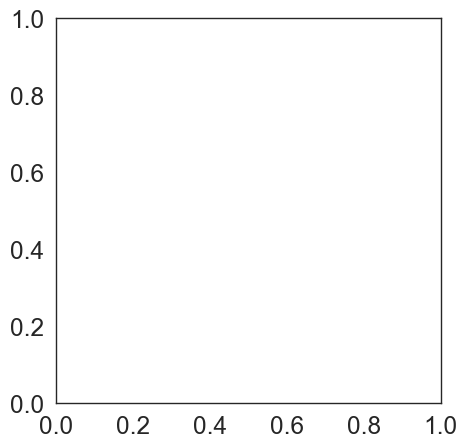

In [92]:
plot_map_stations_cv(st_test)